In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="3"

Wed Jan 17 23:14:56 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   37C    P0    64W / 300W |   9053MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.prior.spiral_prior import Prior
from model.latent.dmin_latent import Latent
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]
hp.M = 1024
hp.N = 256

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 6.004646301269531
encoder.convs 5.989013671875
encoder.linear 0.01563262939453125
prior 0.0
latent 0.0
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train01.16-11/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, models, opt_g = load(save_dir, 0, models, optimizer)

total 37356
-rw-rw-r-- 1 scpark scpark   277124  1월 17 23:14 events.out.tfevents.1705500684.GPUSVR11
-rw-rw-r-- 1 scpark scpark 37973949  1월 17 23:11 save_0


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=hp.N, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


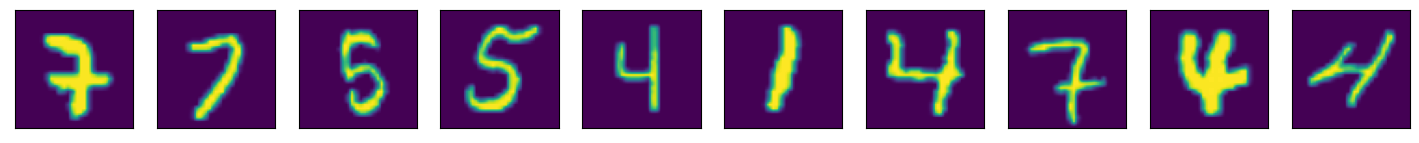

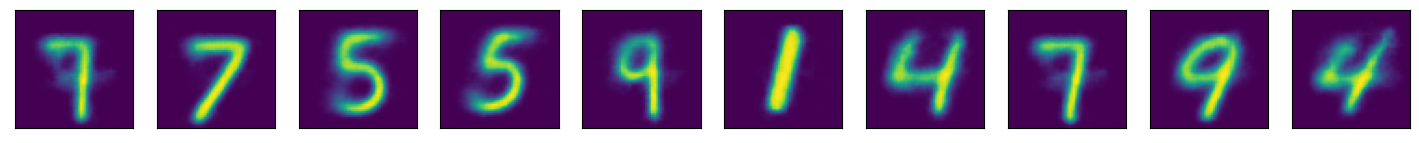

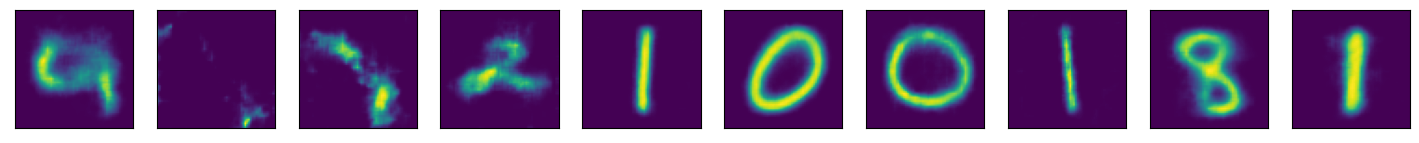

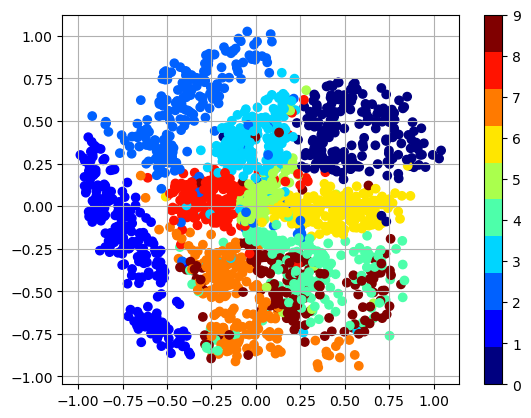

22001
lse_loss 0.004068694543093443
recon_loss 0.092617928981781
22002
lse_loss 0.005016705486923456
recon_loss 0.0918472558259964
22003
lse_loss 0.004515032283961773
recon_loss 0.094460628926754
22004
lse_loss 0.00518144853413105
recon_loss 0.09576250612735748
22005
lse_loss 0.0048012821935117245
recon_loss 0.09039531648159027
22006
lse_loss 0.004597472958266735
recon_loss 0.09176655858755112
22007
lse_loss 0.005040135234594345
recon_loss 0.09355489909648895
22008
lse_loss 0.0044208490289747715
recon_loss 0.09658809006214142
22009
lse_loss 0.004564292263239622
recon_loss 0.09708118438720703
22010
lse_loss 0.004657492507249117
recon_loss 0.09772901237010956
22011
lse_loss 0.005039115436375141
recon_loss 0.09676732867956161
22012
lse_loss 0.005451217759400606
recon_loss 0.09967073798179626
22013
lse_loss 0.004454880487173796
recon_loss 0.0938061997294426
22014
lse_loss 0.005080066621303558
recon_loss 0.09770416468381882
22015
lse_loss 0.004273092374205589
recon_loss 0.09734179824590683


22126
lse_loss 0.004279863089323044
recon_loss 0.10213185846805573
22127
lse_loss 0.004685723222792149
recon_loss 0.10063230991363525
22128
lse_loss 0.0040778848342597485
recon_loss 0.0965917557477951
22129
lse_loss 0.004954239819198847
recon_loss 0.10216666758060455
22130
lse_loss 0.0049821967259049416
recon_loss 0.102513387799263
22131
lse_loss 0.005173309240490198
recon_loss 0.0950179323554039
22132
lse_loss 0.005109717138111591
recon_loss 0.0960092544555664
22133
lse_loss 0.005282850470393896
recon_loss 0.10049307346343994
22134
lse_loss 0.004935043398290873
recon_loss 0.09710656106472015
22135
lse_loss 0.00448374031111598
recon_loss 0.10053814947605133
22136
lse_loss 0.004844921641051769
recon_loss 0.09262283891439438
22137
lse_loss 0.004487309604883194
recon_loss 0.09410473704338074
22138
lse_loss 0.004526231903582811
recon_loss 0.09677445888519287
22139
lse_loss 0.004820726811885834
recon_loss 0.0958855003118515
22140
lse_loss 0.005041650962084532
recon_loss 0.09571248292922974


22251
lse_loss 0.004347759298980236
recon_loss 0.09425093978643417
22252
lse_loss 0.004656780511140823
recon_loss 0.09505429118871689
22253
lse_loss 0.005711037665605545
recon_loss 0.09524299949407578
22254
lse_loss 0.0062174079939723015
recon_loss 0.09935373067855835
22255
lse_loss 0.004715276416391134
recon_loss 0.10084643959999084
22256
lse_loss 0.005047272425144911
recon_loss 0.09444978833198547
22257
lse_loss 0.00452441954985261
recon_loss 0.09681922197341919
22258
lse_loss 0.004491935484111309
recon_loss 0.09380680322647095
22259
lse_loss 0.004685861989855766
recon_loss 0.09127126634120941
22260
lse_loss 0.004176300019025803
recon_loss 0.09320595860481262
22261
lse_loss 0.004543038550764322
recon_loss 0.09682248532772064
22262
lse_loss 0.004909604787826538
recon_loss 0.09941583126783371
22263
lse_loss 0.0056857154704630375
recon_loss 0.09547364711761475
22264
lse_loss 0.00398712232708931
recon_loss 0.09074632823467255
22265
lse_loss 0.004958444740623236
recon_loss 0.1035900264978

22376
lse_loss 0.004906901624053717
recon_loss 0.09901341050863266
22377
lse_loss 0.005466185975819826
recon_loss 0.09607113897800446
22378
lse_loss 0.004963340237736702
recon_loss 0.09924518316984177
22379
lse_loss 0.004354038741439581
recon_loss 0.09809346497058868
22380
lse_loss 0.004677238408476114
recon_loss 0.09043599665164948
22381
lse_loss 0.004570758901536465
recon_loss 0.09857235848903656
22382
lse_loss 0.005028313025832176
recon_loss 0.09293429553508759
22383
lse_loss 0.005317438393831253
recon_loss 0.0960235446691513
22384
lse_loss 0.005143153481185436
recon_loss 0.09449445456266403
22385
lse_loss 0.004314723890274763
recon_loss 0.09248313307762146
22386
lse_loss 0.004907404072582722
recon_loss 0.09647759795188904
22387
lse_loss 0.005329051520675421
recon_loss 0.09804871678352356
22388
lse_loss 0.004578863736242056
recon_loss 0.09423641860485077
22389
lse_loss 0.004714560694992542
recon_loss 0.09473954141139984
22390
lse_loss 0.004831625148653984
recon_loss 0.09082162380218

lse_loss 0.005381520371884108
recon_loss 0.09177380800247192
22501
lse_loss 0.005051354877650738
recon_loss 0.09174492210149765
22502
lse_loss 0.004821857903152704
recon_loss 0.10296551883220673
22503
lse_loss 0.004865633323788643
recon_loss 0.09942065179347992
22504
lse_loss 0.004630072973668575
recon_loss 0.0992407351732254
22505
lse_loss 0.00433581555262208
recon_loss 0.09614207595586777
22506
lse_loss 0.0046738525852561
recon_loss 0.09160453081130981
22507
lse_loss 0.004936743527650833
recon_loss 0.09605038166046143
22508
lse_loss 0.005111796781420708
recon_loss 0.0953645408153534
22509
lse_loss 0.004641999956220388
recon_loss 0.08988704532384872
22510
lse_loss 0.004491955507546663
recon_loss 0.1019602045416832
22511
lse_loss 0.005311003886163235
recon_loss 0.08693750947713852
22512
lse_loss 0.004971503745764494
recon_loss 0.10065438598394394
22513
lse_loss 0.00612946692854166
recon_loss 0.10228171944618225
22514
lse_loss 0.004701181314885616
recon_loss 0.09742245078086853
22515
ls

22623
lse_loss 0.004926737863570452
recon_loss 0.09777140617370605
22624
lse_loss 0.004893072880804539
recon_loss 0.09916709363460541
22625
lse_loss 0.004110170993953943
recon_loss 0.09568857401609421
22626
lse_loss 0.004780872259289026
recon_loss 0.09854033589363098
22627
lse_loss 0.00511088315397501
recon_loss 0.0971139669418335
22628
lse_loss 0.004162188619375229
recon_loss 0.09396638721227646
22629
lse_loss 0.004977680742740631
recon_loss 0.09381519258022308
22630
lse_loss 0.004767940379679203
recon_loss 0.09422101825475693
22631
lse_loss 0.004655920900404453
recon_loss 0.09510590136051178
22632
lse_loss 0.004631589632481337
recon_loss 0.09236469119787216
22633
lse_loss 0.004633014090359211
recon_loss 0.09232161939144135
22634
lse_loss 0.0037310714833438396
recon_loss 0.0969298928976059
22635
lse_loss 0.0049796150997281075
recon_loss 0.10052486509084702
22636
lse_loss 0.004901593551039696
recon_loss 0.09560655057430267
22637
lse_loss 0.004776048008352518
recon_loss 0.09409045428037

lse_loss 0.004485676996409893
recon_loss 0.10277360677719116
22748
lse_loss 0.004586808383464813
recon_loss 0.09625522792339325
22749
lse_loss 0.00467997370287776
recon_loss 0.09265343844890594
22750
lse_loss 0.004902333952486515
recon_loss 0.09673222154378891
22751
lse_loss 0.004575715400278568
recon_loss 0.09737463295459747
22752
lse_loss 0.004750104155391455
recon_loss 0.0996546670794487
22753
lse_loss 0.004804356023669243
recon_loss 0.09320314973592758
22754
lse_loss 0.004188348073512316
recon_loss 0.09726035594940186
22755
lse_loss 0.004242478404194117
recon_loss 0.09491302818059921
22756
lse_loss 0.004409754648804665
recon_loss 0.09276045858860016
22757
lse_loss 0.004633315838873386
recon_loss 0.10309647023677826
22758
lse_loss 0.00498315691947937
recon_loss 0.09933239221572876
22759
lse_loss 0.004529398400336504
recon_loss 0.09707681834697723
22760
lse_loss 0.004561309702694416
recon_loss 0.09765197336673737
22761
lse_loss 0.004959891550242901
recon_loss 0.09469407796859741
2276

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            data = model(data, M=hp.M)

            # Backward
            loss = 0
            for key in data.keys():
                if 'kl_loss' in key:
                    loss = loss + data[key] * 0.00025
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
        
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model = model_list[0]
            model.eval()
            with torch.no_grad():
                data = model(data, M=hp.M)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [11]:
save_model_list(save_dir, step, model_list, optimizer_list)